# This is the Data Modelling of the data set provided by The Lending Club for all the loans listed as accepted from year 2007 to year 2018 Q2. The Data has been cleaned already and cleaned data set is loaded from clean_loan.csv.

In [1]:
%matplotlib inline

# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [2]:
from sklearn.model_selection import train_test_split

from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [3]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# read 'clean_loan.csv'  dataset as a dataframe
clean_loan = pd.read_csv('clean_loan.csv', low_memory =  False, index_col = 0)
clean_loan.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1890721 entries, 0 to 1939178
Data columns (total 23 columns):
id                      1890721 non-null float64
loan_amnt               1890721 non-null float64
term                    1890721 non-null int64
int_rate                1890721 non-null float64
installment             1890721 non-null float64
grade                   1890721 non-null object
home_ownership          1890721 non-null object
annual_inc              1890721 non-null float64
verification_status     1890721 non-null object
issue_d                 1890721 non-null object
purpose                 1890721 non-null object
dti                     1890721 non-null float64
inq_last_6mths          1890721 non-null float64
open_acc                1890721 non-null float64
pub_rec                 1890721 non-null float64
revol_bal               1890721 non-null float64
revol_util              1890721 non-null float64
total_acc               1890721 non-null float64
application_

### As we found in Exploratory Data Analysis that fico_score and dti are two valuable features that we are going to use to model and predict if loan is going to default or not.

In [5]:
# Create a smaller dataframe with required features
df = clean_loan.loc[:,['dti','fico_score', 'loan_amnt', 'default', 'issue_d']]
df = df.reset_index(drop=True)
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%Y-%m-%d')

In [6]:
group = df.groupby(df.issue_d.dt.year).agg(np.sum)
loan_amnt = group.loan_amnt

### This is classification problem with 2 possible target values of 0 = no default and 1 = default. We will be using several classification algorithms from scikit-learn library.

### Also this is an imbalance dataset with less than 10% rows with default = 1 values. So we take a subset of the loan data which has equal number of default and no default rows. 

In [7]:
# Create a subset with equal number of taget values and then randomize the data
cnt = 163351
loanstatus_0 = df[df["default"]==0]
loanstatus_1 = df[df["default"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n = cnt, replace = False )
subset_of_loanstatus_1 = loanstatus_1.sample(n = cnt, replace = False )

#sort both subsets
subset_of_loanstatus_0.sort_values('issue_d', inplace = True)
subset_of_loanstatus_1.sort_values('issue_d', inplace = True)

# take 80 % of no default and 80 % default and make training set
set_size = int(cnt / 10)
training_set1 = subset_of_loanstatus_0.iloc[:set_size * 8]
test_set1 = subset_of_loanstatus_0.iloc[set_size * 8:]

training_set2 = subset_of_loanstatus_1.iloc[:set_size * 8]
test_set2 = subset_of_loanstatus_1.iloc[set_size * 8:]

training_set = pd.concat([training_set1, training_set2])
test_set = pd.concat([test_set1, test_set2])

training_set = training_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)

Xtrain = training_set.drop(['loan_amnt', 'default', 'issue_d'], axis = 1)
Xtest = test_set.drop(['loan_amnt', 'default', 'issue_d'],axis = 1)

ytrain = training_set.loc[:,'default']
ytest = test_set.loc[:,'default']

In [8]:
# Create train and test datasets of 80/20 ratio
#X = loan.drop('default', axis = 1)   
#y =  loan.default
#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 42)
test_ar = []

## Helper Functions

In [9]:
# Function 'calculate_scores' to calculate different statistical results and to store them in test_arr to be displayed later
def calculate_scores(lbl, no_fit_clf): 
    no_fit_clf.fit(Xtrain, ytrain)
    clf = no_fit_clf.best_estimator_
    #print(clf)
    pred_prob = clf.predict_proba(Xtest)[:,1]
          
    training_accuracy = clf.score(Xtrain, ytrain)
    #print("Accuracy score on training data: {:0.2f}".format(training_accuracy))

    # Now perform tests on test data set
    # test data set accuracy score
    test_accuracy = clf.score(Xtest, ytest)
    #print("Accuracy Score on test data:     {:0.2f}".format(test_accuracy))
    
    roc_auc = roc_auc_score(ytest, pred_prob)
    #print("AUC Score:                       {:0.2f}".format(roc_auc))
       
    y_pred = clf.predict(Xtest)
    cm = confusion_matrix(ytest, y_pred)
    
    rmse = np.sqrt(mean_squared_error(ytest, y_pred))
    #print("RMSE Score:                     {:0.2f}".format(rmse))
    
    fpr, tpr, thresh = roc_curve(ytest, pred_prob)
        
    test_ar.append({'label':lbl, 'fpr' : fpr, 'tpr':  tpr, 'auc' : roc_auc, 'rmse': rmse, 'cm' :cm, 'test_acc': test_accuracy, 'tr_acc' : training_accuracy})   

In [10]:
# Function plots roc-auc curve for test data set for different classifiers
def plot_roc_auc_curve():
    for i in range(len(test_ar)):
        fpr = test_ar[i]['fpr']
        tpr = test_ar[i]['tpr']
        auc = test_ar[i]['auc']
        label = test_ar[i]['label']
        plt.plot(fpr, tpr, lw=2, label= label +'(AUC = %0.2f)' % auc)
        
    plt.plot([0, 1], [0, 1], color='green', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve For Test Data Set') #Receiver Operating Characteristic 
    plt.legend(loc="lower right", fontsize = 12)
    plt.show()

In [11]:
# Function to plot root mean square error of different classifiers for test data set as bar graph
def plot_rmse():
    rmse = []
    label = []
    x = np.linspace(0, len(test_ar)-1, len(test_ar))

    for i in range(len(test_ar)):
        rmse.append(test_ar[i]['rmse'])
        label.append(test_ar[i]['label'])
    g = sns.barplot(x, rmse)
    plt.title('Root Mean Square Error For Test Data Set')
    plt.xlabel('Classifiers')
    plt.ylabel('RMSE Value')
    plt.ylim([0.5, 0.75])
    plt.xticks(x, label, rotation='vertical')

    rects = g.patches
    for rect, i in zip(rects, range(len(test_ar))):
        height = rect.get_height()
        g.text(rect.get_x() + rect.get_width()/2, height, ('%0.2f' % test_ar[i]['rmse']), ha='center', va='bottom')
    plt.show()

In [12]:
# Function to plot accuracy score of training and test data sets for different classifiers as bar graph
def plot_accuracy_score():
    t_acc = []
    tr_acc= []
    label = []
    x = np.linspace(0, len(test_ar)-1, len(test_ar))

    for i in range(len(test_ar)):
        t_acc.append(test_ar[i]['test_acc'])
        label.append(test_ar[i]['label'])
        tr_acc.append(test_ar[i]['tr_acc'])

    ax1 = plt.subplot(1,2,1)
    g = sns.barplot(x, tr_acc, ax = ax1)
    plt.title('Training Data Set Accuracy Score')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy Score')
    plt.ylim([0.5, 0.65])
    plt.xticks(x, label, rotation='vertical')
    rects = g.patches
    for rect, i in zip(rects, range(len(test_ar))):
        height = rect.get_height()
        g.text(rect.get_x() + rect.get_width()/2, height, ('%0.2f' % tr_acc[i]), ha='center', va='bottom')

    ax2 = plt.subplot(1,2,2)
    g = sns.barplot(x, t_acc, ax = ax2)
    plt.title('Test Data Set Accuracy Score')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy Score')
    plt.ylim([0.5, 0.65])
    plt.xticks(x, label, rotation='vertical')
    rects = g.patches
    for rect, i in zip(rects, range(len(test_ar))):
        height = rect.get_height()
        g.text(rect.get_x() + rect.get_width()/2, height, ('%0.2f' % t_acc[i]), ha='center', va='bottom')

    plt.show()

In [13]:
# Function to plot precision and recall for different classifiers
def plot_precision_recall():
    precision = []
    recall = []
    label = []
    x = np.linspace(0, len(test_ar)-1, len(test_ar))

    for i in range(len(test_ar)):
        cm = test_ar[i]['cm']
        tn, fp, fn, tp = cm.ravel()
        pr = tp/(tp+ fp)
        rec = tp/(tp+fn)
        precision.append(pr)
        recall.append(rec)
        label.append(test_ar[i]['label'])

    ax1 = plt.subplot(1,2,1)
    g1 = sns.barplot(x= x, y = precision, ax = ax1)
    plt.title('Precision for Test Data Set')
    plt.xlabel('Classifiers')
    plt.ylabel('Precision values')
    plt.ylim([0.4, 0.75])
    plt.xticks(x, label, rotation='vertical')
    rects = g1.patches
    for rect, i in zip(rects, range(len(test_ar))):
        height = rect.get_height()
        g1.text(rect.get_x() + rect.get_width()/2, height, ('%0.2f' % precision[i]), ha='center', va='bottom')

    ax2 = plt.subplot(1,2,2)
    g2 = sns.barplot(x= x, y = recall, ax = ax2)
    plt.title('Recall for Test Data Set')
    plt.xlabel('Classifiers')
    plt.ylabel('Recall values')
    plt.ylim([0.4, 0.75])
    plt.xticks(x, label, rotation='vertical')
    plt.tight_layout(pad = 4)
    rects = g2.patches
    for rect, i in zip(rects, range(len(test_ar))):
        height = rect.get_height()
        g2.text(rect.get_x() + rect.get_width()/2, height, ('%0.2f' % recall[i]), ha='center', va='bottom')

    plt.show()

In [14]:
# Function to plot confusion Matrix for Test Data Set for different classifiers
def plot_confusion_matrix():
    cmap=plt.cm.Blues
    classes = ['No Default', 'Default']
    for i in range(len(test_ar)):
        cm = test_ar[i]['cm']
        lbl = test_ar[i]['label']
        df_cm = pd.DataFrame(cm, index = classes, columns = classes)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        df_cm_norm = pd.DataFrame(cm_norm, index = classes, columns = classes)

        fig, big_axes = plt.subplots(figsize=(10, 4) , nrows=1, ncols=1) 
        big_axes.set_title("Confusion Matrix for " + lbl, fontsize = 13)

        # Turn off axis lines and ticks of the big subplot 
        # obs alpha is 0 in RGBA string!
        big_axes.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        # removes the white frame
        big_axes._frameon = False

        ax1 = fig.add_subplot(1,2,1)
        sns.heatmap(df_cm, annot=True, cmap = cmap, fmt = 'd', ax = ax1)
        ax1.set_title('without normalization', loc = 'left')
        ax1.set_ylabel('True label')
        ax1.set_xlabel('Predicted label')

        ax2 = fig.add_subplot(1,2,2)
        sns.heatmap(df_cm_norm, annot=True, cmap = cmap, fmt = '.2f', ax = ax2) 
        ax2.set_title('with normalization', loc= 'right')
        ax2.set_ylabel('True label')
        ax2.set_xlabel('Predicted label')

        plt.tight_layout(pad = 2)
        plt.show()
        

## Models

### 1. Logistic Regression
###### Logistic Regression is one of the basic regression alogorithm used for predicting a catgorical target variable. We used a GridSearchCV() to estimate the best value of hyperparamter 'C' and to do the cross validation with 5 folds.

In [15]:
#print('Logistic Regression')
clf = LogisticRegression()
p_grid =  {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
gs_clf = GridSearchCV(clf, param_grid=p_grid, cv=5, scoring = 'accuracy')

calculate_scores('Logistic Regression', gs_clf)

### 2. Random Forest
###### A random forest is an Ensemble classifier fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).
###### Different hyperparameter values are selected based on the best results of experiments done on this dataset. We used a GridSearchCV() to estimate the best value of hyperparamters and to do the cross validation with 5 folds

In [16]:
# Number of trees in random forest
n_estimators = [150]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [10]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
p_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion':['entropy']}
#print(p_grid)

In [17]:
#print('Random Forest')
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, p_grid, cv=5, scoring='accuracy')

calculate_scores('Random Forest', rf_grid)

### 3. K Nearest Neighbors(KNN) 
###### KNN algorithm is one of the simplest classification algorithm. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors.
###### GridSearchCV is used to estimate the best value of hyperparameter and to perform cross validation using 5 folds together.

In [18]:
#print('K Nearest Neighbors(KNN)')
clf = KNeighborsClassifier()
#p_grid =  {"n_neighbors": [20, 25, 30, 35,40, 45]}
p_grid =  {"n_neighbors": [100]}
gs_knn = GridSearchCV(clf, p_grid, cv=5, scoring='accuracy')

calculate_scores('K Nearest Neighbors', gs_knn)

### 4. BaggingClassifier
###### BaggingClassifier is an ‘ensemble’ method. Bagging constructs n classification trees using bootstrap sampling of the training data and then combines their predictions to produce a final meta-prediction. GridSearchCV is used to estimate the best value of hyperparameter and to perform cross validation using 5 folds together.

In [19]:
#print('Bagging with DecisionTree')
base_clf = KNeighborsClassifier(n_neighbors = 100)
clf = BaggingClassifier() 
p_grid = {'n_estimators': [50], 'base_estimator':[base_clf], 'random_state':[7], 'max_features':[2], 'warm_start': [True]}
bg_grid = GridSearchCV(clf, p_grid, cv=5, scoring='accuracy')

calculate_scores('Bagging Classifier', bg_grid)

### 5. AdaBoost classification with DecisionTree
###### Adaptive Boosting is used with other types of learning algorithms to improve performance. The output of the other learning algorithms ('weak learners') is combined into a weighted sum that represents the final output of the boosted classifier. AdaBoost is adaptive in the sense that subsequent weak learners are tweaked in favor of those instances misclassified by previous classifiers.

In [20]:
#print('AdaBoost with DecisionTree')
p_grid = {'n_estimators': [50], 'base_estimator':[None], 'learning_rate':[1]}
clf = AdaBoostClassifier()
Ab_grid = GridSearchCV(clf, p_grid, cv=5, scoring='accuracy')

calculate_scores('AdaBoost Classifier', Ab_grid)

## Results

### 1. Area Under ROC Curve
###### The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The best possible prediction method would yield a point in the upper left corner or coordinate (0,1) of the ROC space, representing 100% sensitivity (no false negatives) and 100% specificity (no false positives). The diagonal divides the ROC space. Points above the diagonal represent good classification results; points below the line represent bad results. A predictor with largest AUC value performs the best.
###### In the plot below, AdaBoost Classifier and Random Forest classifiers performed best with AUC = 0.63. Logistic Regression perfomed second best with AUC = 0.62.

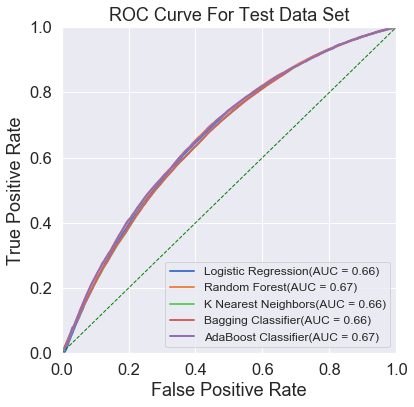

In [21]:
sns.set()
sns.set(font_scale = 1.5)
sns.set_palette("muted")
 
# Set figure width and height
plt.rcParams["figure.figsize"] = [6,6]

plot_roc_auc_curve()

### 2. Root Mean Square Error
###### RMSE of an estimator measures the square root of average of the squares of the errors—that is, the square root of average squared difference between the estimated values and actual values. The RMSE is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better. 
###### In the bar graph below AdaBoost, Random Forest and Logistic Regression performed best as minimum RMSE value of 0.64.

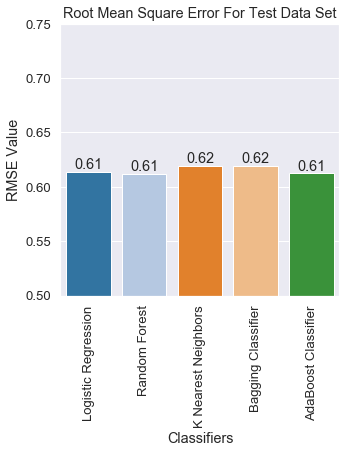

In [22]:
# plot the rmse bar graph for test Data Set
sns.set()
sns.set(font_scale = 1.2)
sns.set_palette("tab20")
 
# Set figure width and height
plt.rcParams["figure.figsize"] = [5,5]
plot_rmse()

### 3. Accuracy Score
###### Classification accuracy score is the number of correct predictions made divided by the total number of predictions made.
###### The bar graphs below show the comparison of accuracy scores for both training data set and test dataset. Bagging classifier did best for training set but not too good for test data set. AdaBoost, Random Forest and Logistic Regression classifiers performed best with accuracy score of 0.59.

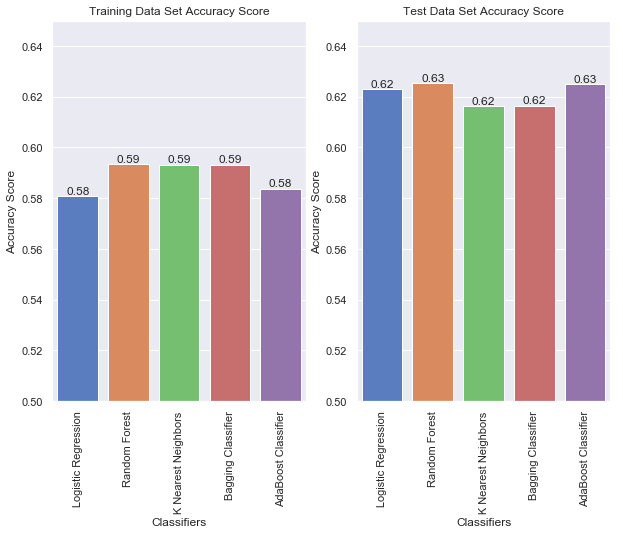

In [23]:
# plot the Test and training set accuracy score bar graph
sns.set()
sns.set(font_scale = 1)
sns.set_palette("muted")
 
# Set figure width and height
plt.rcParams["figure.figsize"] = [10,7]

plot_accuracy_score()

### 4. Precision and Recall
###### Precision is about how precise/accurate the model is out of those predicted positive, how many of them are actual positive. Recall actually calculates how many of the Actual Positives the model capture through labeling it as Positive (True Positive). Recall shall be the model metric used to select the best model when there is a high cost associated with False Negative.
###### The comparison of Precision and Recall values below in the bar graphs show that Adaboost peformed best with Recall value of 0.70.

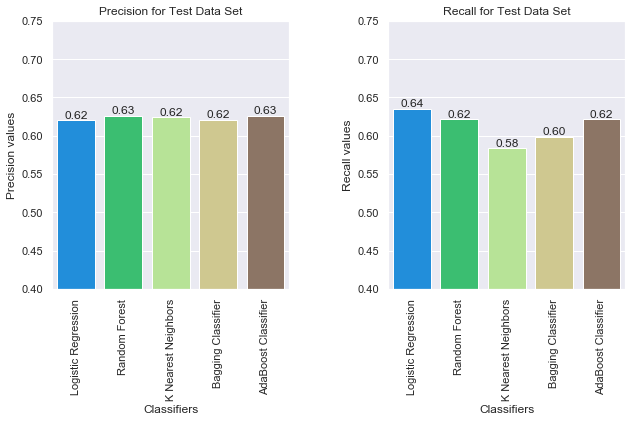

In [24]:
# plot the precision/recall bar graph for test Data Set
sns.set()
sns.set(font_scale = 1)
sns.set_palette("terrain")

# Set figure width and height
plt.rcParams["figure.figsize"] = [10,7]

plot_precision_recall()

### 5. Confusion Matrix
###### A table of confusion or confusion matrix, is a table with two rows and two columns that reports the number of false positives, false negatives, true positives, and true negatives. This allows more detailed analysis than mere proportion of correct classifications (accuracy).
###### The plots below show the confusion matrix for each of the predictors.

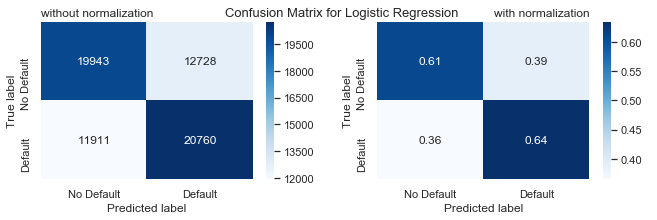

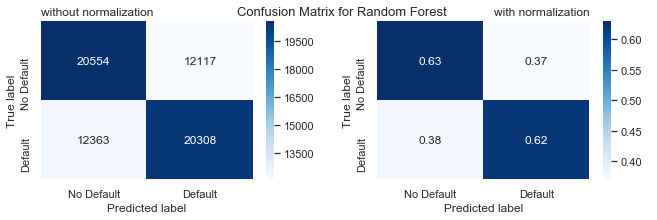

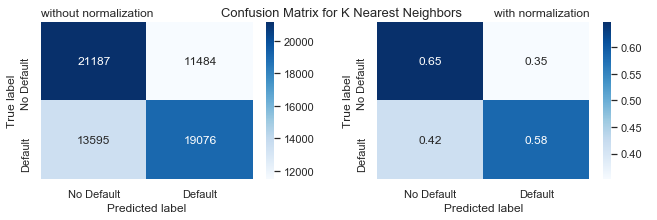

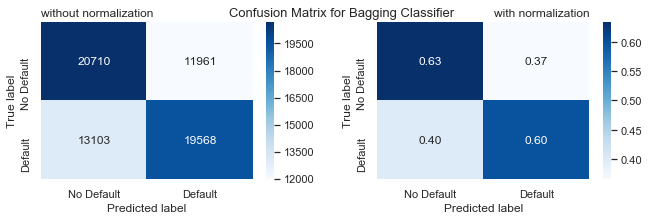

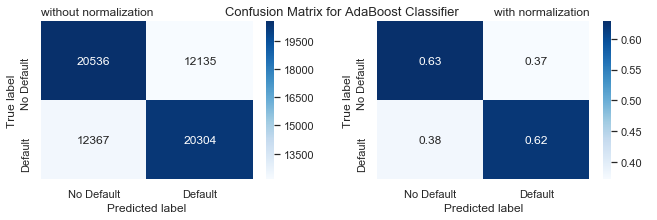

In [25]:
# plot the confusion matrix for test Data Set
sns.set()
plot_confusion_matrix()

## Assumptions
###### 1. The Lending Club Dataset of all accepted loans from year 2007 to Q2 2018 is an imbalance dataset with very small number of loan applications which were defaulted. So we used the 'Charged off' loan status as an indicator of default.
###### 2. Most of the features in the dataset represented information which are not available to investors at the time of loan applictaion. These features were provided by The lending Club after or during the loan approval process. So we used the features 'fico score' and 'dti' which are available to investors as the independent variables for our analysis.


In [26]:
# Conclusion results using AdaBoost
clf = Ab_grid.best_estimator_
y_pred = clf.predict(Xtest)
fn_df = test_set.copy()
r = []
fn_df['predict'] = y_pred
for i in range(0, y_pred.size):
    if ((test_set.default[i] == 0)  | (y_pred[i] == 0)) :
        r.append(i)
fn_df.drop(r, 0, inplace = True)
fn_df.reset_index(drop = True, inplace = True)

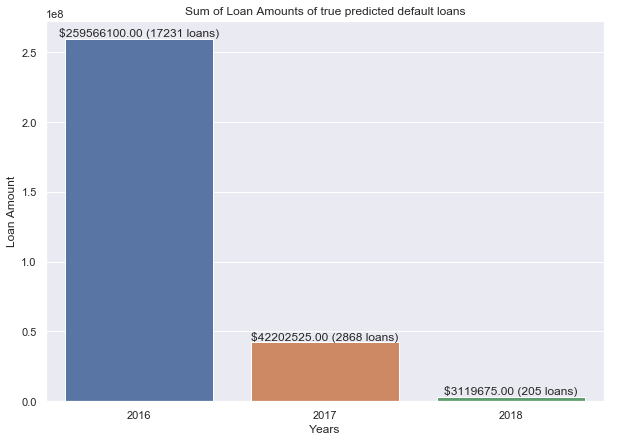

In [27]:
group = fn_df.groupby(fn_df.issue_d.dt.year).agg(np.sum)
loan_amnt = group.loan_amnt

group1 = fn_df.groupby(fn_df.issue_d.dt.year).agg(np.count_nonzero)
count = group1.loan_amnt

#print(loan_amnt)
#print(count)
x = np.linspace(0, len(loan_amnt)-1, len(loan_amnt))
g = sns.barplot(x, loan_amnt)
label=[2016, 2017, 2018]

plt.title('Sum of Loan Amounts of true predicted default loans')
plt.xlabel('Years')
plt.ylabel('Loan Amount')
plt.xticks(x, label)

rects = g.patches
for rect, i in zip(rects, range(len(loan_amnt))):
    height = rect.get_height()
    g.text(rect.get_x() + rect.get_width()/2, height, 
           ('$%0.2f (%d loans)' %(loan_amnt[label[i]], count[label[i]])), ha='center', va='bottom')
plt.show()

## Conclusion
###### Predicting Loan Default in The Lending Club dataset is a real business problem. The Loan entries in the dataset have already been screened through the existing algorithms to predict the loan defaults. This makes 'predicting loan default' from this dataset a highly difficult problem. This exercise tried to estimate an improvement over the existing solution.
###### I ran 5 classification algorithms and got best AUC score of 0.63, best accuracy score of 0.59, best recall value of 0.70 and best precision value of 0.58. These scores are good considering the fact that the problem is highly difficult real business problem.
###### The above graph shows that among all the loans accepted in first 2 quarters of 2018, 202 loans for a total of almost 3 million dollars are predicted default correctly. During the year 2017, 2864 loans for a total of almost 42 million dollars are predicted default correctly. So this exercise actually add values to The Lending Club business.
